# Mining TED Talk Scripts

In [1]:
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
from contraction import CONTRACTION_MAP
import unicodedata
import matplotlib.pyplot as plt

## Importing TED data and TED Scripts

In [2]:
transcript = pd.read_csv('transcripts.csv')
ted = pd.read_csv('ted_main.csv')
ted_new = ted[['main_speaker','related_talks','tags','title','url']]
data = pd.merge(transcript,ted_new,on='url')

## Wrangling before Mining

  Data Wrangling is an important process before applying machine learning algorithmns. Especially for text below are the major Data Wrangling steps. They are

- Removing Accented characters
- Expanding Contractions
- Removing Special Characters
- Removing Stop Words
- Lemmatization
- Stemming
- Removing unnecessary White spaces

### Removing Accented Characters

Accented Charcters are the characters have accents or symbols above them. Replacing them with normal charcters is important before analysis. Examples of accented charcters are á, à, â, é, è, ê, í, ì, î, ó

In [3]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [4]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

### Expanding Contractions

Contractions are common in English Language. Contractions are like aren't,isn't,they've,they're . For Semantic analysis expanding them help to identify the negation effects in text and negative sentiments.

In [5]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

### Removing Special Characters

TED Scripts are the text from a talk, there is a chance for several special charcters. Removing the special chaarcters are essential for further analysis.


In [6]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, ' ', text)
    return text

### Lemmatization

Lemmatization consider the morphological forms of words. Example lemmatozation consider 'studies','studies','studying' are considered as the root word 'study'. This helps to identify all these words as a single word and finding frequency based on them, instead of considering each as separate identity.

In [7]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [8]:
transcript['transcript_clean'] = transcript.transcript.apply(remove_accented_chars)
transcript['transcript_clean'] = transcript.transcript_clean.apply(expand_contractions)


In [9]:
transcript['transcript_clean'] = transcript.transcript_clean.apply(remove_special_characters)

### Removing White Spaces

While typo there are lot of chances for having unwanted white spaces.sometimes words with and without spaces are considered as different words

In [10]:
def remove_whitespace(x):
    try:
        # remove spaces inside and outside of string
        x = " ".join(x.split())

    except:
        pass
    return x

In [11]:
transcript['transcript_clean'] = transcript.transcript_clean.apply(remove_whitespace)

### Removing Stopwords

Text contains stopwords like 'the','an,'he','is','was' those words are just fillers, but when analysing sentiments those words does not have any impact so those can be removed. For current analysis the words 'no' and 'not' are removed from stopwords list as they will clearly identify the neagtive sentiments.

In [12]:
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')


In [13]:
Text=transcript['transcript_clean'].tolist()

## tf-idf Vectorization

The Input type that machine learning algorithms understand are the numeric vectors, so it is necessary to convert texts into numneric vectors. tf-idf stands for Term Freqency - Inverse Document Frequency. Term frequency gives the frequency of the word in each document.It is the ratio of number of times the word appears in a document compared to the total number of words in that document. Inverse Document Frequency used to calculate the weight of rare words across all documents in the corpus.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words=stopword_list,
                                 use_idf=True,  ngram_range=(1,3))


In [15]:
%time tfidf_matrix = tfidf_vectorizer.fit_transform(Text) 


Wall time: 36.5 s


In [16]:
terms = tfidf_vectorizer.get_feature_names()

## Similarity

There are several similarity measures available most prominent are __Jaccard,Cosine,Euclidean distance and Manhattan distance.__

__Cosine similarity__ metric finds the normalized dot product of the two attributes. By determining the cosine similarity, we would effectively try to find the cosine of the angle between the two objects. The cosine of 0° is 1, and it is less than 1 for any other angle.

It is thus a judgement of orientation and not magnitude: two vectors with the same orientation have a cosine similarity of 1, two vectors at 90° have a similarity of 0, and two vectors diametrically opposed have a similarity of -1, independent of their magnitude.

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
df_dist = pd.DataFrame(dist)

# Clustering

Clustering is a technique for finding subgroups or clustersin a dataset. It looks for homogeneous subgroups among groups. There are two best-known clustering approaches __K-Means and Hierarchical Clustering.__

## K-Means Clustering

By K-Means Clustering a data set can be segregated into K distinct, non-overlapping clusters. K needs to be decided before the algorithm application. 

Let C1,...,CK denote sets containing the indices of the observations in each cluster.

__These sets satisfy two properties:__

__*  1.C1 ∪ C2 ∪...∪ CK={1,...,n}. In other words, each observation belongs to at least one of the Kclusters.__

__*  2.Ck ∩ Ck1 = ∅ for all k1!=k__


### Algorithm

-  __Step 1 : Randomly assign a value to k__
-  __Step 2 : Compute the centroid of each cluster__
-  __Step 3 : Assign eaach observation to the cluster with closest centroid__
-  __Step 4 : Repeat steps 2 and 3 till the clusters stop changing__

## k = 10

In [18]:
from sklearn.cluster import KMeans

num_clusters = 10

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()


Wall time: 1min 33s


In [19]:
clust = pd.Series(clusters,name='cluster')

In [20]:
new = data.join(clust)

In [21]:
new['title'][new.cluster == 3]

3                                     Greening the ghetto
7                  Behind the design of Seattle's library
10           My wish: A call for open-source architecture
18                     Organic design, inspired by nature
50                      The hidden world of shadow cities
73                        How architecture can connect us
89                                Cradle to cradle design
102                    The ghastly tragedy of the suburbs
103                                 Human-centered design
112                             A memorial at Ground Zero
160                       The sticky wonder of gecko feet
174                                   Treat design as art
183                                    A song of the city
189                                   Building uniqueness
196               On the verge of creating synthetic life
199                              My days as a young rebel
203                      My green agenda for architecture
227           

> When k =10, mostly the clusters involving topics as Women but some talks related to science and art also included. Let us increase the cluster size.

## k=20

In [22]:
from sklearn.cluster import KMeans

num_clusters = 20

km_20 = KMeans(n_clusters=num_clusters)

%time km_20.fit(tfidf_matrix)

clusters_20 = km_20.labels_.tolist()


Wall time: 1min 28s


In [23]:
clust_20 = pd.Series(clusters_20,name='cluster')

In [24]:
new_20 = data.join(clust_20)

In [25]:
new_20['title'][new_20.cluster == 4]

23                              Why we love, why we cheat
24                             Happiness in body and soul
101                                       "Black Men Ski"
131                                    Patient capitalism
169                                      Tales of passion
289                             What security means to me
449             A passionate, personal case for education
541                      The surprising spread of Idol TV
562                        Photographing the hidden story
584                               Embrace your inner girl
643                    Radical women, embracing tradition
782                 Women, wartime and the dream of peace
790      A feminine response to Iceland's financial crash
791                                         A call to men
793                         New data on the rise of women
798                     Why we have too few women leaders
805     A test that finds 3x more breast tumors, and w...
819           

> After considering k=20, the clustering becomes meaningful, in the above cluster the talks about __Women__ are clearly grouped.

## Hierarchical Clustering

Rather than choosing clusters in k-means, hierarchical clustering consider each data point as one cluster. Next data point will be added to the previous cluster if it is close by. Process will be repeated till we get one giant cluster. The history tree thus formed is called a __Dendrogram.__

In [26]:

new['title']= new['title'].str.replace('$','s')
t = new['title'].values

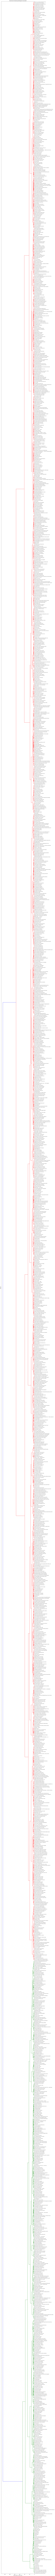

In [31]:
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
Z = hierarchy.linkage(df_dist, 'ward')

plt.subplots(figsize=(10, 800)) # set size

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.xticks(rotation=0)
plt.ylabel('distance')
 
 
# Plot with Custom leaves
hierarchy.dendrogram(Z,orientation='left',leaf_font_size=8, labels=t)
plt.show()

Above Dendrogram is the resultant hierarchical clustering based on cosine similarity.Finally all the clusters linked to one big cluster. The orientation is made as 'left' for better visualization. To understand the distance between clusters we can visualize only part of the tree by parameter __truncated_mode__.

In [32]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [33]:

plt.figure(figsize=(15,10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=100,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=5,
   # max_d=19,
)
plt.show()

> In the above dendrogram, when considering left part of it we can see __cluster at height of 10.9, merge to the next cluster at height of 37.2__, so distance between clusters is 26.3. It can be easily decided to cutoff the cluster at a height of 10.9, but if we analyze further __the left most cluster height of 18.6 merge to a cluster only at a height of 48.1,difference leads to 29.5.__

> So let us consider the __cutoff distance be 19 i.e. max_d = 19__

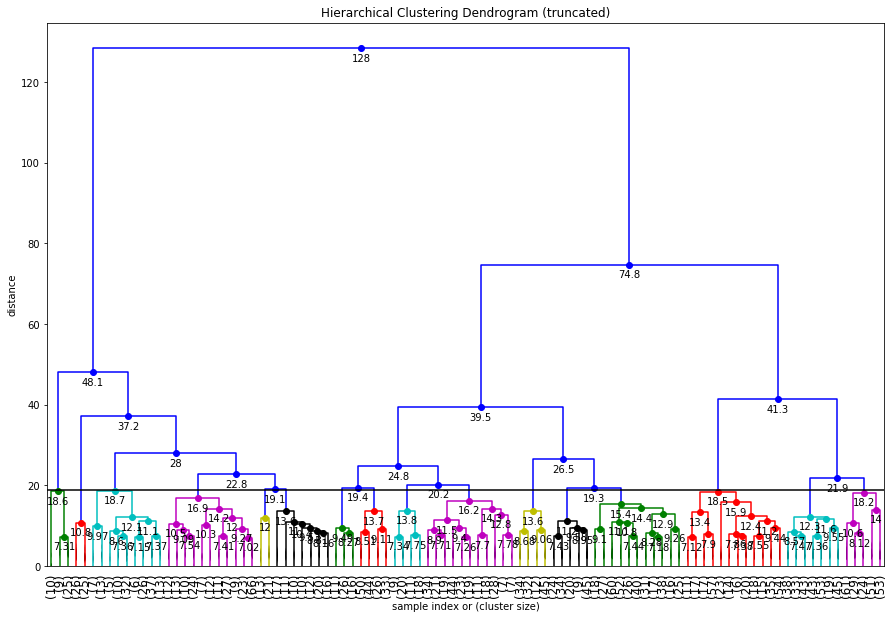

In [34]:
plt.figure(figsize=(15,10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=100,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=5,
    max_d=19,
)
plt.show()

In [35]:
from scipy.cluster.hierarchy import fcluster
max_d = 19
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([14, 14, 16, ..., 10, 14,  9], dtype=int32)

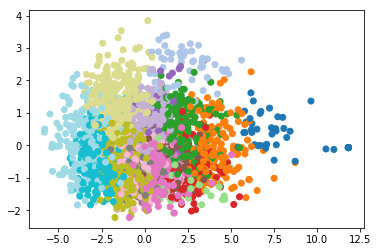

In [69]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
dist_pca = pca.fit_transform(dist) 
x, y = dist_pca[:, 0], dist_pca[:, 1]

plt.scatter(x, y, c=clusters,cmap='tab20')  # plot points with cluster dependent colors
plt.show()

In [36]:
plt.figure(figsize=(10, 8))
plt.scatter(dist[:,0], dist[:,1], c=clusters, cmap='prism')  # plot points with cluster dependent colors
plt.show()

In [37]:
final = pd.DataFrame({'cluster':clusters,'title':t})

### Cluster depicting the __issues and improvements in different parts of the world (Geography)__

In [49]:
final['title'][final.cluster == 11]

4                         The best stats you've ever seen
33                    How mobile phones can fight poverty
36                          How to rebuild a broken state
51           Global priorities bigger than climate change
62                             My wish: Rebuilding Rwanda
108                   Salvation (and profit) in greentech
109                 Want to help Africa? Do business here
115                               New insights on poverty
125                       Africa's cheetahs versus hippos
128                                  Why invest in Africa
136                            Aid for Africa? No thanks.
152                   A commodities exchange for Ethiopia
230                                  The "bottom billion"
291                             Health and the human mind
298                Politics and religion are technologies
342                                    The future of cars
373             A solar energy system that tracks the sun
439           

### Cluster depicting the __Topics related to Women__

In [62]:
final['title'][final.cluster == 2]

449             A passionate, personal case for education
541                      The surprising spread of Idol TV
562                        Photographing the hidden story
643                    Radical women, embracing tradition
782                 Women, wartime and the dream of peace
791                                         A call to men
793                         New data on the rise of women
798                     Why we have too few women leaders
819                           Drawing on humor for change
824                    Social media and the end of gender
829                     Mother and daughter doctor-heroes
836                       On being a woman and a diplomat
889         The mothers who found forgiveness, friendship
906                                          Art in exile
967            Compassion and the true meaning of empathy
1068           Women entrepreneurs, example not exception
1111                                   Listening to shame
1150          

### Cluster depicting __Technology and Data (Computers,Big Data,Robots,Smartphones etc)__

In [64]:
final['title'][final.cluster == 5]

397                                          The next web
433                                The mathematics of war
453               A university for the coming singularity
606         Is Pivot a turning point for web exploration?
610                     The year open data went worldwide
717                      The beauty of data visualization
742                                   The quantified self
815                Visualizing the medical data explosion
816                                  Silicon-based comedy
955                  Are we filtering the wrong microbes?
963                          Beware conflicts of interest
1001                                   Art made of storms
1142                             Texting that saves lives
1170               Revealing the lost codex of Archimedes
1244               The rise of human-computer cooperation
1406     If cars could talk, accidents might be avoidable
1478              Better baby care -- thanks to Formula 1
1610          